In [15]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [14, 10]

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

import imgaug as ia

from retinanet.encoder import DataEncoder
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss

from pikachu_dataset import load_data_pikachu

DEVICE  = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:

class PikachuDataset(Dataset):
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
    
        encoder = DataEncoder()
        if self.anchor_areas is not None:
            encoder.anchor_areas = self.anchor_areas  # p3 -> p7
            
        self.encoder = encoder 
        
    def __len__(self):
        return 900
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):
    

        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]
        

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
        
def down_sample(in_channels,out_channels):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                 nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                  nn.MaxPool2d(2,2)
                 
                 )

class SimpleSSD(nn.Module):
    
    
    def __init__(self, n_cls=1, num_anchors=9):
        super(SimpleSSD, self).__init__()
        
        self.n_cls = n_cls
        self.num_anchors = num_anchors
        
        
        # Base CNN (think resnet/vgg or other base network)
        self.step1 = down_sample(3, 128)
        self.step2 = down_sample(128, 128)
        
        self.step3 = down_sample(128, 128)
        self.step4 = down_sample(128, 128)
        self.step5 = down_sample(128, 128)

        self.cls_head1 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head1 = nn.Conv2d(128, self.num_anchors *4, 3, padding=1)
        
        self.cls_head2 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head2 = nn.Conv2d(128,self.num_anchors * 4,3, padding=1)
        
        self.cls_head3 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head3 = nn.Conv2d(128, self.num_anchors * 4,3, padding=1)
        
        
    def forward(self, x):
        
        step1=self.step1(x)
        step2=self.step2(step1)

        step3=self.step3(step2)
        step4 = self.step4(step3)
        step5 = self.step5(step4)
        
    
        cls1 = self.cls_head1(step3)
        bbox1 = self.bbox_head1(step3)
        
        cls2 = self.cls_head2(step4)
        bbox2 = self.bbox_head2(step4)
        
        cls3 = self.cls_head3(step5)
        bbox3 = self.bbox_head3(step5)
    
        cls1 = cls1.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls2 = cls2.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls3 = cls3.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        
        bbox1 = bbox1.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox2 = bbox2.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox3 = bbox3.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
      
        cls_pred = torch.cat([cls1, cls2, cls3], dim=1)
        bbox_pred = torch.cat([bbox1, bbox2, bbox3], dim=1)
        
        return bbox_pred, cls_pred
                

    

In [42]:
train, val = load_data_pikachu(1)
train.next().data[0].shape

(1, 3, 256, 256)

In [43]:
train.next().label[0].shape

(1, 1, 5)

In [20]:
pikachu_ds = PikachuDataset(anchor_areas=[8*8.,16*16.,32*32])
pikachu_dl = DataLoader(pikachu_ds, batch_size=2, collate_fn=pikachu_ds.collate_func)



#for b in pikachu_dl:
#    image, bounding_boxes, labels = b

In [50]:
pikachu_ds[0][0][0].shape

torch.Size([3, 256, 256])

AttributeError: 'Tensor' object has no attribute 'asnumpy'

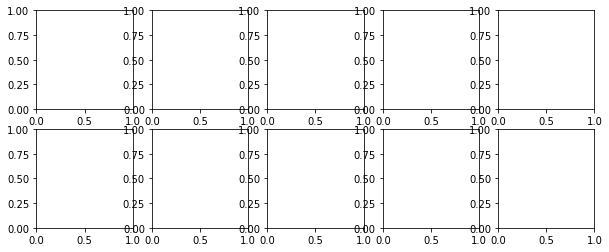

In [54]:
import d2l
img = pikachu_ds[0][0].squeeze().permute(1,2,0) / 255
axes = d2l.show_images(img, 2, 5).flatten()
for ax, label in zip(axes, pikachu_ds[0].label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

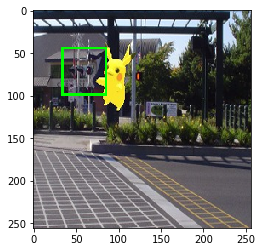

In [13]:
image = pikachu_ds[0][0].squeeze().permute(1,2,0) / 256

anchors = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in pikachu_ds[0][1].numpy()], shape=(256, 256))

image_to_show = anchors.draw_on_image(image, thickness=3)
plt.imshow(image_to_show)

In [6]:
import ipywidgets as widgets

def f(x):
    plt.figure()
    print(pikachu_ds[x][0].shape)
    print(pikachu_ds[x][0].squeeze().shape)
    plt.imshow(pikachu_ds[x][0].squeeze().permute(1,2,0) / 256)


widgets.interact(f, x=(0,len(pikachu_ds)-1));

interactive(children=(IntSlider(value=449, description='x', max=899), Output()), _dom_classes=('widget-interac…

In [7]:
model= SimpleSSD(1)
model = model.to(DEVICE)
criterion = FocalLoss(num_classes=1)

In [8]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
collect = []
for epoch in range(10):
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(DEVICE)
        bounding_boxes = bounding_boxes.to(DEVICE)
        labels = labels.to(DEVICE)
        loc_pred, cls_pred = model(image)
        #loc_pred.to(DEVICE)
        #cls_pred.to(DEVICE)
        #bounding_boxes.to(DEVICE)
        #labels.to(DEVICE)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
        print(total_loss)
        collect.append([total_loss.detach().cpu().numpy()])


/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(3170.6660, grad_fn=<AddBackward0>)
tensor(3135.1047, grad_fn=<AddBackward0>)
tensor(3127.0955, grad_fn=<AddBackward0>)
tensor(3083.0298, grad_fn=<AddBackward0>)
tensor(3049.7878, grad_fn=<AddBackward0>)
tensor(2986.0430, grad_fn=<AddBackward0>)
tensor(2986.7048, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [ ]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float)[100:].plot(subplots=True)

# Visualize

In [ ]:
i = 0

bbspred, labelpred, score  = pikachu_ds.encoder.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    image[i].detach().cpu().numpy(),0, 2)  # moveaxis does the same as reshape

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))

### Exercises

-  Load a custom image with pikachu( or many ) and try to make predictiosn with the network and visualize the result
-  Can you think of anything that could confuse our detector? yellow dots ?
- Currently the code is not really modular, try to make it nice by splitting it into logical parts
    - Base feature extractor Module
    - Head Creator module
- Currently the detection/cls HEADS are very simple (just one CONV layer) they can be more complex. Try using more convolutions, check other architectures how its done

- Can you use our network to train using some new data for instance:
    - https://www.kaggle.com/tomluther/ships-in-google-earth
    - https://www.kaggle.com/aruchomu/data-for-yolo-v3-kernel
    - https://www.kaggle.com/dataturks/face-detection-in-images
    - https://www.kaggle.com/dataturks/face-dataset-with-age-emotion-ethnicity  
 You will need to create a data loader/data sets similar as we did for the pikachu loader. 
